# Machine Learning Assigment

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import skimage as sk
from PIL import Image
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, voting_classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from sklearn.svm import SVC
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, ZeroPadding2D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
import warnings
import random
from random import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import random
from scipy import ndarray
from skimage import transform
from skimage import util
from sklearn.metrics import confusion_matrix
from statistics import mode

warnings.filterwarnings("ignore")

# Import and Cleaning

In [2]:
# Importing data
df = pd.read_csv('attribute_list.csv', skiprows=1)#row 1 are for coloumns name so we skip it: skiprows=1

# reading pictures. Returning as np.array. Color level: RGB
#Black and white color saves us time 
#and is more simple to handle in binary decisions and 
#don't affect accuracy


def read_pic(name, as_black_white=False):   
    string = 'dataset/' + str(name) + '.png'
    if as_black_white == True:
        return(np.array(Image.open(string).convert(mode='L')))
    else:
        return(np.array(Image.open(string)))

# Cleaning data: data where each column are labeled "-1" are noises
def clean_data():
    tmp = df[['hair_color', 'eyeglasses', 'smiling', 'young', 'human']]
    tmp['sum'] = tmp.sum(axis=1)
    t = tmp[tmp['sum'] == -5]
    return(t.index + 1)
df.drop(labels=clean_data()-1, inplace=True)

# Converting (-1,1) to (0, 1)
df['eyeglasses'] = (df['eyeglasses'] + 1) / 2
df['smiling'] = (df['smiling'] + 1) / 2
df['young'] = (df['young'] + 1) / 2
df['human'] = (df['human'] + 1) / 2

df['eyeglasses'] = df['eyeglasses'].apply(lambda x: int(x))
df['smiling'] = df['smiling'].apply(lambda x: int(x))
df['young'] = df['young'].apply(lambda x: int(x))
df['human'] = df['human'].apply(lambda x: int(x))

# Importing Pictures: we have the choice to decide either in B&W or not and 
# either it's for hair color task or binary task

def import_pictures_bw(data, _as_black_white=True, for_hair=False):
    res = []
    if for_hair == True:
        df_hair = data[data['hair_color'] != -1] #if it's for hair color we remove data where value are missing: labeled "-1"
        file_names = np.array(df_hair['file_name'])
        print("Number of pictures to load for hair: ", file_names.shape )
    else:
        file_names = np.array(data['file_name'])
        print("Number of pictures to load for binary case: ", file_names.shape)
    for k in file_names:
        res.append(read_pic(k, as_black_white=_as_black_white)) # Data are alredy cleaned
    
    return(np.array(res), file_names)


#import same dataset, but transform the pictures, so it can be used to train models and avoid overfitting

def import_pictures_bw_trans(data, _as_black_white=True, for_hair=False):
    res = []
    if for_hair == True:
        df_hair = data[data['hair_color'] != -1]
        file_names = np.array(df_hair['file_name'])
        nb_to_load = file_names.shape + file_names.shape + file_names.shape
        print("Number of pictures to load for hair: ", nb_to_load)
    else:
        file_names = np.array(data['file_name'])
        nb_to_load = file_names.shape + file_names.shape + file_names.shape
        print("Number of pictures to load for binary case: ", nb_to_load)
    for k in file_names:
        key = random.choice(list(available_transformations)) #chose randomly one of the tranformation in the list 
                                                            #defined below in the "transformation function part"
        transformed_image = available_transformations[key](read_pic(k, as_black_white=_as_black_white))
        res.append(transformed_image) #transform the image and add it to the array
    
    return(np.array(res), file_names)

# this function is used to divide data set. we set it by defaut to 83% training and 17% test. 
# We use it later when we create final model that serve to predict data. It is useful in order 
# to export the csv file in the desired format: we can keep image number and its corresponding prediction (as the data is suffled, without this, we could not associate image number and prediction)

def createSets(file_names, prop=5./6): 
    indexMax = int(prop*len(file_names))
    sample = np.random.permutation(len(file_names))
    #sample = (len(file_names))
    return(sample, indexMax) 

# Transformation function

In [3]:
def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]
# create list of available transformation
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}


### Importing transformed pictures

##### importing randomly transformed pictures for binary case in b&w 

In [4]:
#e use it later when we create final model that serve to predict data. 
#We need multiple importation to implement a voting system

pics_binary_bw_trans1, file_name_binary_bw_trans1 = import_pictures_bw_trans(df, _as_black_white=True, for_hair=False)
pics_binary_bw_trans2, file_name_binary_bw_trans2 = import_pictures_bw_trans(df, _as_black_white=True, for_hair=False)
pics_binary_bw_trans3, file_name_binary_bw_trans3 = import_pictures_bw_trans(df, _as_black_white=True, for_hair=False)
pics_binary_bw_trans4, file_name_binary_bw_trans4 = import_pictures_bw_trans(df, _as_black_white=True, for_hair=False)

Number of pictures to load for binary case:  (4565, 4565, 4565)
Number of pictures to load for binary case:  (4565, 4565, 4565)
Number of pictures to load for binary case:  (4565, 4565, 4565)
Number of pictures to load for binary case:  (4565, 4565, 4565)


# Preprocessing for black and white pictures

### Import pictures in _black_ and _white_ and scaling.

In [5]:
################################# importing pictures for hair in b&w ###############################

pics_hair_bw, file_name_hair_bw = import_pictures_bw(df, _as_black_white=True, for_hair=True)
print(pics_hair_bw.shape)



################################ importing pictures for binary case in b&w ########################

pics_binary_bw, file_name_binary_bw = import_pictures_bw(df, _as_black_white=True, for_hair=False)
print(pics_binary_bw.shape)






Number of pictures to load for hair:  (3902,)
(3902, 256, 256)
Number of pictures to load for binary case:  (4565,)
(4565, 256, 256)


### Applying  PCA in B&W

In [6]:
# used to reduce data set but keep a minimum defined precision(defaut set at 99%)
# It helps reduce computaional time but keep a certain level of precision. 
# Here as data set is small, it's not vital, but it is always good to use it

def extract_var(tbl, x=.99):
    k = 0
    while tbl[k] < x:
        k = k + 1
    return(k)

# to get linear data
def to_vector(data):
    res = []
    for k in range(len(data)):
        res.append(data[k].ravel())
    return(np.array(res))



pics_hair_bw_PCA = np.array([preprocessing.scale(pics_hair_bw[k]) for k in range(len(pics_hair_bw))])
pics_binary_bw_PCA = np.array([preprocessing.scale(pics_binary_bw[k]) for k in range(len(pics_binary_bw))])


######################################## Apply PCA for hair ###########################################

pics_lin_hair_PCA = to_vector(data = pics_hair_bw_PCA)

pca = PCA()
pca.fit(pics_lin_hair_PCA)

# searching for number of component to keep
v_exp = np.cumsum(pca.explained_variance_ratio_)


k99 = extract_var(v_exp, x=.99)
pca99 = PCA(n_components=k99)




s = time.time()

X_hair_bw_PCA = pca99.fit_transform(pics_lin_hair_PCA)

print('X_hair_bw_PCA.shape', X_hair_bw_PCA.shape)
print('Time to compute the PCA for hair (99% precision): ' + str(int(100*(time.time() - s)/60)/100) + ' min')
print('')


######################################## Apply PCA for binary case ###########################################


pics_lin_binary_PCA = to_vector(data = pics_binary_bw_PCA)


pca = PCA()
pca.fit(pics_lin_binary_PCA)

# searching for number of component to keep
v_exp = np.cumsum(pca.explained_variance_ratio_)


k99 = extract_var(v_exp, x=.99)
pca99 = PCA(n_components=k99)


u = time.time()

X_binary_bw_PCA = pca99.fit_transform(pics_lin_binary_PCA)

print('X_binary_bw_PCA', X_binary_bw_PCA.shape)
print('Time to compute the PCA for binary case (99% precision): ' + str(int(100*(time.time() - u)/60)/100) + ' min')
print('')







X_hair_bw_PCA.shape (3902, 2546)
Time to compute the PCA for hair (99% precision): 3.11 min

X_binary_bw_PCA (4565, 2809)
Time to compute the PCA for binary case (99% precision): 3.98 min



### Applying NMF in B&W

In [7]:
######################################## Apply NMF for hair ###########################################


s = time.time()

pics_lin_hair_NMF = to_vector(data=pics_hair_bw)

#nmf.fit(pics_lin)
nmf = NMF(n_components=15)  #we used nmf with base 15
X_hair_bw = nmf.fit_transform(pics_lin_hair_NMF)
X_hair_bw_NMF = preprocessing.scale(X_hair_bw)



print('Time to compute nmf.fit_transform for hair: ' + str(int(100*(time.time() - s)/60)/100) + ' min')


######################################## Apply NMF for binary case ###########################################

t = time.time()

pics_lin_binary_NMF = to_vector(data=pics_binary_bw)

#nmf.fit(pics_lin)
nmf = NMF(n_components=15)  #we used nmf with base 15
X_binary_bw = nmf.fit_transform(pics_lin_binary_NMF)
X_binary_bw_NMF = preprocessing.scale(X_binary_bw)


print('Time to compute nmf.fit_transform for binary data case: ' + str(int(100*(time.time() - t)/60)/100) + ' min')



Time to compute nmf.fit_transform for hair: 2.54 min
Time to compute nmf.fit_transform for binary data case: 2.58 min


### Apply NMF to transformed data B&W

#### Apply NMF for binary transformed

In [8]:
pics_lin_binary_NMF_trans1 = to_vector(data=pics_binary_bw_trans1)
pics_lin_binary_NMF_trans2 = to_vector(data=pics_binary_bw_trans2)
pics_lin_binary_NMF_trans3 = to_vector(data=pics_binary_bw_trans3)
pics_lin_binary_NMF_trans4 = to_vector(data=pics_binary_bw_trans4)

s = time.time()
# NMF trans1 
nmf = NMF(n_components=15)  #we used nmf with base 15
X_binary_bw_trans1 = nmf.fit_transform(pics_lin_binary_NMF_trans1)
X_binary_bw_NMF_trans1 = preprocessing.scale(X_binary_bw_trans1)
print('Time to compute nmf.fit_transform for binary transformed 1: ' + str(int(100*(time.time() - s)/60)/100) + ' min')
print('')




t = time.time()
# NMF trans2 
nmf = NMF(n_components=15)  #we used nmf with base 15
X_binary_bw_trans2 = nmf.fit_transform(pics_lin_binary_NMF_trans2)
X_binary_bw_NMF_trans2 = preprocessing.scale(X_binary_bw_trans2)
print('Time to compute nmf.fit_transform for binary transformed 2: ' + str(int(100*(time.time() - t)/60)/100) + ' min')
print('')




u = time.time()
# NMF trans3 
nmf = NMF(n_components=15)  #we used nmf with base 15
X_binary_bw_trans3 = nmf.fit_transform(pics_lin_binary_NMF_trans3)
X_binary_bw_NMF_trans3 = preprocessing.scale(X_binary_bw_trans3)
print('Time to compute nmf.fit_transform for binary transformed 3: ' + str(int(100*(time.time() - u)/60)/100) + ' min')
print('')



v = time.time()
# NMF trans4 
nmf = NMF(n_components=15)  #we used nmf with base 15
X_binary_bw_trans4 = nmf.fit_transform(pics_lin_binary_NMF_trans4)
X_binary_bw_NMF_trans4 = preprocessing.scale(X_binary_bw_trans4)
print('Time to compute nmf.fit_transform for binary transformed 4: ' + str(int(100*(time.time() - v)/60)/100) + ' min')
print('')


Time to compute nmf.fit_transform for binary transformed 1: 2.49 min

Time to compute nmf.fit_transform for binary transformed 2: 2.49 min

Time to compute nmf.fit_transform for binary transformed 3: 2.21 min

Time to compute nmf.fit_transform for binary transformed 4: 2.09 min



# Preprocessing in color

### Importing picture in color with hexadecimal code

In [9]:
# note that we could have used the following function to import pictures in color:
# import_pictures_bw(df, _as_black_white=False, for_hair=True) (with as_black_white set at False)
# But this would return images in rgb coloring with a shape of: 256*256*3 (3 dimension) 
# which is not adapted to certain 
# functions such a scaling. For ease we hence use the following code to convert rgb to hexadecimal
# and manipulate picture with shape 256*256 only (2D)


def rgb2dec(img):
    res = np.zeros(shape=(img.shape[0],img.shape[1]))
    for k in range (img.shape[0]):
        for l in range (img.shape[1]):
            r,g,b = img[k][l][0], img[k][l][1], img[k][l][2]
            hx = "#{:02x}{:02x}{:02x}".format(r,g,b)
            res[k][l] = int(hx[1:], 16)
            
    
    return(res)



def import_pictures_color(data, for_hair=False): #difference importing hair color data and others as we 
                                                    #need to missing data for hair color
    res = []
    if for_hair == True:
        df2 = data[data['hair_color'] != -1]
        file_names = np.array(df2['file_name'])
        print("Number of pictures to load:", file_names.shape)
    else:
        file_names = np.array(data['file_name'])
        print("Number of pictures to load:", file_names.shape)
    for k in file_names:
        string = 'dataset/' + str(k) + '.png'
        tmp = np.array(Image.open(string))
        res.append(rgb2dec(tmp)) # Data are alredy cleaned
       
    return(np.array(res),file_names)
    
# Loading data

#if data are already loaded, set compute to False (by defaut). This is a gain of time, as the process to import and 
#convert the large image data set in color and convert it to hexadecimal code takes around 40 min for hair AND 40 min 
#for binary cases. This is why, with the code, has beeen provided the zib file of the pictured colored in hexa.
#to be able to read them, one just need to unzip them and put them in the same folder as this program.The code will 
#automatically seach them and upload then (takes only few seconds)
#However, if one desire to re-create those files to be sure that the program create the desired dataset corectly, it
#is just needed to set compute to True. But again, it will take a total of around 80-90 min.
#Due to important data size, the files have been uploaded on google drive and a link has been given in the 
#report to get access to it (it was too heavy for github or moodle submission)


# set compute here, wheter you want to generate files (compute = True) 
# or if you already have them in folder (compute = False)
compute = False
s = time.time()
if compute == True:
    
    s = time.time()
    
    colored_pic_for_hair, file_name_hair_col = import_pictures_color(df, for_hair=True)
    np.save('Colored_decimal_pictures_for_hair', colored_pic_for_hair)
    np.save('File_name_hair_colored_pic', file_name_hair_col) # save data as it takes lot of time to generate.
                                                              # We hence just need to generate once
                                                                
    print('finish hair')
    colored_pic_binary_case, file_name_binary_col = import_pictures_color(df,for_hair=False)
    np.save('Colored_decimal_pictures_binary_case', colored_pic_binary_case)
    np.save('File_name_binary_colored_pic', file_name_binary_col)
    
    print("Time to compute this part:" + str(int(100*(time.time() - s)/60)/100) + ' min')
    compute = False
else:
   
    colored_pic_for_hair = np.load('Colored_decimal_pictures_for_hair.npy')
    colored_pic_binary_case = np.load('Colored_decimal_pictures_binary_case.npy')
    file_name_hair_col = np.load('File_name_hair_colored_pic.npy')
    file_name_binary_col = np.load('File_name_binary_colored_pic.npy')
    
    
print("Time to load data:" + str(int(100*(time.time() - s)/60)/100) + ' min')
print("Data Loaded!")
print("Colored_decimal_pictures_for_hair: ", colored_pic_for_hair.shape)
print("Colored_decimal_pictures_binary_case: ", colored_pic_binary_case.shape)   

Time to load data:0.09 min
Data Loaded!
Colored_decimal_pictures_for_hair:  (3902, 256, 256)
Colored_decimal_pictures_binary_case:  (4565, 256, 256)


### Applying NMF in color

In [10]:
################################# NMF for hair in color ##########################################

s = time.time()

lin_pics_color_for_hair = to_vector(data=colored_pic_for_hair)

#nmf.fit(pics_lin)
nmf = NMF(n_components=15)
X_hair_col = nmf.fit_transform(lin_pics_color_for_hair)
X_hair_col_NMF = preprocessing.scale(X_hair_col)



print('Time to compute nmf.fit_transform for hair: ' + str(int(100*(time.time() - s)/60)/100) + ' min')

################################ NMF for binary cases in color ###################################

t = time.time()

lin_pics_color_binary_case = to_vector(data=colored_pic_binary_case)

#nmf.fit(pics_lin)
nmf = NMF(n_components=15)
X_binary_col = nmf.fit_transform(lin_pics_color_binary_case)
X_binary_col_NMF = preprocessing.scale(X_binary_col)
print('Time to compute nmf.fit_transform for binary data case: ' + str(int(100*(time.time() - t)/60)/100) + ' min')


# NMF gives more accuracy for colored data rather than pca

Time to compute nmf.fit_transform for hair: 2.07 min
Time to compute nmf.fit_transform for binary data case: 2.41 min


### Applying PCA in color

In [11]:
################################## PCA for hair in color ####################################

s = time.time()



X_hair_col_PCA = np.array([preprocessing.scale(colored_pic_for_hair[k]) for k in range(len(colored_pic_for_hair))])
X_hair_col_PCA = to_vector(data=X_hair_col_PCA)

pca = PCA()
pca.fit(X_hair_col_PCA)

# searching for number of component to keep
v_exp = np.cumsum(pca.explained_variance_ratio_)

k99 = extract_var(v_exp, x=.99)
pca99 = PCA(n_components=k99)

X_hair_col_PCA = pca99.fit_transform(X_hair_col_PCA)

print('Time to compute PCA for hair in color: ' + str(int(100*(time.time() - s)/60)/100) + ' min')





################################## PCA for binary case in color ####################################

t = time.time()


X_binary_col_PCA = np.array([preprocessing.scale(colored_pic_binary_case[k]) for k in range(len(colored_pic_binary_case))])
X_binary_col_PCA = to_vector(data=X_binary_col_PCA)

pca = PCA()
pca.fit(X_binary_col_PCA)


# searching for number of component to keep
v_exp = np.cumsum(pca.explained_variance_ratio_)

k99 = extract_var(v_exp, x=.99)
pca99 = PCA(n_components=k99)

X_binary_col_PCA = pca99.fit_transform(X_binary_col_PCA)

print('Time to compute PCA for binary data case in color: ' + str(int(100*(time.time() - t)/60)/100) + ' min')

Time to compute PCA for hair in color: 5.27 min
Time to compute PCA for binary data case in color: 7.03 min


# Human or Cartoon 

### In black and white

In [13]:
t = time.time()

Y_human = np.array(df['human'])


###################################### Cross validation score #############################################

#cv = 6 means that the model will train on 5 data and test on 1. 
#It moves the selected 6 data step by step till end of dataset given. 
#Doing this, it reduces risk of overfitting when claculation scores

#mlp classifier
c1_h_bw_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_NMF, Y_human, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_h_bw_NMF) + '%')

c1_h_bw_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_PCA, Y_human, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_h_bw_PCA) + '%')
print('')


# Random Forest classifier (gini)
c2_h_bw_NMF = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_bw_NMF, Y_human, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_h_bw_NMF) + '%')

c2_h_bw_PCA = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_bw_PCA, Y_human, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_h_bw_PCA) + '%')
print('')



# SVM linear kernel
c3_h_bw_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_NMF, Y_human, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_h_bw_NMF) + '%')

c3_h_bw_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_PCA, Y_human, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_h_bw_PCA) + '%')
print('')



# SVM polynomial kernel
c4_h_bw_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_NMF, Y_human, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_h_bw_NMF) + '%')

c4_h_bw_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_PCA, Y_human, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_h_bw_PCA) + '%')
print('')


print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')

Cross Validation score for MLP classifier with NMF preprocessing: 99.23308943616297%
Cross Validation score for MLP classifier with PCA preprocessing: 98.37897760143215%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 98.31333206205231%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 94.32668145067868%

Cross Validation score for SVM linear kernel with NMF preprocessing: 97.26159275477522%
Cross Validation score for SVM linear kernel with PCA preprocessing: 98.9701331099606%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 98.1159348995201%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 97.63393945483281%

Time to compute this part: 5.45 min


### In color

In [14]:
t = time.time()



Y_human = np.array(df['human'])


###################################### Cross validation score #############################################

#mlp classifier
c1_h_col_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_col_NMF, Y_human, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_h_col_NMF) + '%')

c1_h_col_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_col_PCA, Y_human, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_h_col_PCA) + '%')
print('')


# Random Forest classifier (gini)
c2_h_col_NMF = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_col_NMF, Y_human, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_h_col_NMF) + '%')

c2_h_col_PCA = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_col_PCA, Y_human, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_h_col_PCA) + '%')
print('')


# SVM linear kernel
c3_h_col_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_NMF, Y_human, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_h_col_NMF) + '%')

c3_h_col_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_PCA, Y_human, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_h_col_PCA) + '%')
print('')



# SVM polynomial kernel
c4_h_col_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_NMF, Y_human, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_h_col_NMF) + '%')

c4_h_col_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_PCA, Y_human, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_h_col_PCA) + '%')
print('')


print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')


Time to compute this part: 0.0 min
Cross Validation score for MLP classifier with NMF preprocessing: 99.21136110450057%
Cross Validation score for MLP classifier with PCA preprocessing: 98.66351862753446%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 97.91911339856983%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 92.48627405260974%

Cross Validation score for SVM linear kernel with NMF preprocessing: 96.8890161228809%
Cross Validation score for SVM linear kernel with PCA preprocessing: 99.21115968723704%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 98.20345270486669%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 97.54624882243132%

Time to compute this part: 6.19 min



# Young or old 

### In black and white

In [15]:
t = time.time()


Y_young = np.array(df['young'])



###################################### Cross validation score #############################################

#mlp classifier
c1_y_bw_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_NMF, Y_young, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_y_bw_NMF) + '%')

c1_y_bw_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_PCA, Y_young, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_y_bw_PCA) + '%')
print('')



# Random Forest classifier (gini)
c2_y_bw_NMF = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_bw_NMF, Y_young, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_y_bw_NMF) + '%')

c2_y_bw_PCA = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_bw_PCA, Y_young, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_y_bw_PCA) + '%')
print('')



# SVM linear kernel
c3_y_bw_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_NMF, Y_young, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_y_bw_NMF) + '%')

c3_y_bw_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_PCA, Y_young, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_y_bw_PCA) + '%')
print('')



# SVM polynomial kernel
c4_y_bw_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_NMF, Y_young, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_y_bw_NMF) + '%')

c4_y_bw_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_PCA, Y_young, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_y_bw_PCA) + '%')
print('')




print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')

Cross Validation score for MLP classifier with NMF preprocessing: 78.88362798795666%
Cross Validation score for MLP classifier with PCA preprocessing: 75.9039356434101%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 79.89052937690832%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 78.72939999831786%

Cross Validation score for SVM linear kernel with NMF preprocessing: 79.16762239649846%
Cross Validation score for SVM linear kernel with PCA preprocessing: 71.87319545107695%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 79.29911496815717%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 79.2770124678118%

Time to compute this part: 12.67 min


### In color

In [16]:
t = time.time()

Y_young = np.array(df['young'])


###################################### Cross validation score #############################################

#mlp classifier
c1_y_col_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_col_NMF, Y_young, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_y_col_NMF) + '%')

c1_y_col_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_col_PCA, Y_young, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_y_col_PCA) + '%')

print('')




# Random Forest classifier (gini)
c2_y_col_NMF = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_col_NMF, Y_young, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_y_col_NMF) + '%')

c2_y_col_PCA = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_col_PCA, Y_young, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_y_col_PCA) + '%')

print('')



# SVM linear kernel
c3_y_col_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_NMF, Y_young, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_y_col_NMF) + '%')

c3_y_col_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_PCA, Y_young, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_y_col_PCA) + '%')

print('')



# SVM polynomial kernel
c4_y_col_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_NMF, Y_young, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_y_col_NMF) + '%')

c4_y_col_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_PCA, Y_young, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_y_col_PCA) + '%')

print('')




print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')


Cross Validation score for MLP classifier with NMF preprocessing: 79.27790421003378%
Cross Validation score for MLP classifier with PCA preprocessing: 74.91769778993755%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 80.74481343361025%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 79.12390668168001%

Cross Validation score for SVM linear kernel with NMF preprocessing: 79.16762239649846%
Cross Validation score for SVM linear kernel with PCA preprocessing: 68.28041686581486%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 79.54011257704758%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 79.25511130909452%

Time to compute this part: 13.91 min


# Smiling or not Smiling 

### In black and white

In [17]:
t = time.time()


Y_smiling = np.array(df['smiling'])



###################################### Cross validation score #############################################

#mlp classifier
c1_s_bw_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_NMF, Y_smiling, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_s_bw_NMF) + '%')

c1_s_bw_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_PCA, Y_smiling, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_s_bw_PCA) + '%')
print('')



# Random Forest classifier (gini)
c2_s_bw_NMF = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_bw_NMF, Y_smiling, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_s_bw_NMF) + '%')

c2_s_bw_PCA = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_bw_PCA, Y_smiling, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_s_bw_PCA) + '%')
print('')



# SVM linear kernel
c3_s_bw_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_NMF, Y_smiling, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_s_bw_NMF) + '%')

c3_s_bw_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_PCA, Y_smiling, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_s_bw_PCA) + '%')
print('')




# SVM polynomial kernel
c4_s_bw_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_NMF, Y_smiling, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_s_bw_NMF) + '%')

c4_s_bw_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_PCA, Y_smiling, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_s_bw_PCA) + '%')
print('')

print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')



Cross Validation score for MLP classifier with NMF preprocessing: 81.38058729068716%
Cross Validation score for MLP classifier with PCA preprocessing: 88.23690355152111%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 81.38018490997293%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 79.60565494964281%

Cross Validation score for SVM linear kernel with NMF preprocessing: 79.60571243260199%
Cross Validation score for SVM linear kernel with PCA preprocessing: 87.88599875159116%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 80.76655295932257%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 85.32285833469932%

Time to compute this part: 9.74 min


### In color

In [20]:
t = time.time()

Y_smiling = np.array(df['smiling'])


###################################### Cross validation score #############################################

#mlp classifier
c1_s_col_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_col_NMF, Y_smiling, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_s_col_NMF) + '%')

c1_s_col_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_col_PCA, Y_smiling, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_s_col_PCA) + '%')
print('')


# Random Forest classifier (gini)
c2_s_col_NMF = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_col_NMF, Y_smiling, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : ' + str(100*c2_s_col_NMF) + '%')

c2_s_col_PCA = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_col_PCA, Y_smiling, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : ' + str(100*c2_s_col_PCA) + '%')
print('')



# SVM linear kernel
c3_s_col_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_NMF, Y_smiling, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_s_col_NMF) + '%')

c3_s_col_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_PCA, Y_smiling, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_s_col_PCA) + '%')
print('')



# SVM polynomial kernel
c4_s_col_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_NMF, Y_smiling, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_s_col_NMF) + '%')

c4_s_col_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_PCA, Y_smiling, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_s_col_PCA) + '%')
print('')


print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')




Cross Validation score for MLP classifier with NMF preprocessing: 81.18293077411937%
Cross Validation score for MLP classifier with PCA preprocessing: 86.19915965056896%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : 80.59125822150023%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : 79.53998051751242%

Cross Validation score for SVM linear kernel with NMF preprocessing: 79.60571243260199%
Cross Validation score for SVM linear kernel with PCA preprocessing: 86.57159219688798%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 81.37989658755136%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 84.07435659777606%

Time to compute this part: 10.71 min


# With or without eyeglasses 

### In black and white

In [22]:
t = time.time()

Y_eyeglasses = np.array(df['eyeglasses'])



###################################### Cross validation score #############################################

#mlp classifier
c1_e_bw_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_e_bw_NMF) + '%')

c1_e_bw_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_e_bw_PCA) + '%')
print('')



# Random Forest classifier (gini)
c2_e_bw_NMF = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_bw_NMF, Y_eyeglasses , cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_e_bw_NMF) + '%')

c2_e_bw_PCA = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_bw_PCA, Y_eyeglasses , cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_e_bw_PCA) + '%')
print('')



# SVM linear kernel
c3_e_bw_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_NMF, Y_eyeglasses , cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_e_bw_NMF) + '%')

c3_e_bw_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_PCA, Y_eyeglasses , cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_e_bw_PCA) + '%')
print('')



# SVM polynomial kernel
c4_e_bw_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_e_bw_NMF) + '%')

c4_e_bw_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_e_bw_PCA) + '%')
print('')

print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')


Cross Validation score for MLP classifier with NMF preprocessing: 83.43944755669285%
Cross Validation score for MLP classifier with PCA preprocessing: 85.71695454435164%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 81.66457141280468%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 73.09945181224711%

Cross Validation score for SVM linear kernel with NMF preprocessing: 81.33677514064112%
Cross Validation score for SVM linear kernel with PCA preprocessing: 85.34532721327393%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 80.72294154582086%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 85.30100701975847%

Time to compute this part: 11.32 min


### In color 

In [23]:
t = time.time()

Y_eyeglasses = np.array(df['eyeglasses'])


###################################### Cross validation score #############################################

#mlp classifier
c1_e_col_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_col_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing : ' + str(100*c1_e_col_NMF) + '%')

c1_e_col_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_col_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing : ' + str(100*c1_e_col_PCA) + '%')
print('')


# Random Forest classifier (gini)
c2_e_col_NMF = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_col_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : ' + str(100*c2_e_col_NMF) + '%')

c2_e_col_PCA = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_binary_col_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : ' + str(100*c2_e_col_PCA) + '%')
print('')



# SVM linear kernel
c3_e_col_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_e_col_NMF) + '%')

c3_e_col_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_e_col_PCA) + '%')
print('')



# SVM polynomial kernel
c4_e_col_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_e_col_NMF) + '%')

c4_e_col_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_e_col_PCA) + '%')
print('')

print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')


Cross Validation score for MLP classifier with NMF preprocessing : 84.49049593392776%
Cross Validation score for MLP classifier with PCA preprocessing : 83.98685830638138%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : 82.93474505732776%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : 73.9535634200715%

Cross Validation score for SVM linear kernel with NMF preprocessing: 83.04471071458761%
Cross Validation score for SVM linear kernel with PCA preprocessing: 83.85568226917552%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 80.78852967787698%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 85.06038342828005%

Time to compute this part: 11.72 min



# Multiclass approach

In [24]:
s = time.time()

Y_multi = np.array(df[['human', 'young','eyeglasses','eyeglasses']])


# RandomForestClassifier
c1_multi = np.mean(cross_val_score(RandomForestClassifier(n_estimators=5000, criterion='entropy'), X_binary_col_NMF, Y_multi, cv=6))
print('Cross Validation score: ' + str(100*c1_multi) + '%')


#mlp classifier
c2_multi = np.mean(cross_val_score(MLPClassifier(), X_binary_col_NMF, Y_multi, cv=6))
print('Cross Validation score for MLP classifier : ' + str(100*c2_multi) + '%')

# K-NN
c3_multi = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=300), X_binary_col_NMF, Y_multi, cv=6))
print('Cross Validation score for SVM polynomial kernel : ' + str(100*c3_multi) + '%')
       


print("Time to compute this part:" + str(int(100*(time.time() - s)/60)/100) + ' min')

Cross Validation score: 66.26466791156604%
Cross Validation score for MLP classifier : 66.4620075155036%
Cross Validation score for SVM polynomial kernel : 61.75210941282246%
Time to compute this part:11.93 min


# Hair color

### defining Y data for hair

In [25]:
df3 = df[df['hair_color'] != -1]
Y_hair = np.array(df3['hair_color'])



#we remove -1 values as they 

### In Black and White

In [26]:
t = time.time()

#mlp classifier
c1_hair_bw_NMF = np.mean(cross_val_score(MLPClassifier(), X_hair_bw_NMF, Y_hair, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing : ' + str(100*c1_hair_bw_NMF) + '%')

c1_hair_bw_PCA = np.mean(cross_val_score(MLPClassifier(), X_hair_bw_PCA, Y_hair, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_hair_bw_PCA) + '%')
print('')


# Random Forest classifier (gini)
c2_hair_bw_NMF = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_hair_bw_NMF, Y_hair, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : ' + str(100*c2_hair_bw_NMF) + '%')

c2_hair_bw_PCA = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_hair_bw_PCA, Y_hair, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : ' + str(100*c2_hair_bw_PCA) + '%')
print('')

# SVM linear kernel
c3_hair_bw_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_hair_bw_NMF, Y_hair, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_hair_bw_NMF) + '%')

c3_hair_bw_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_hair_bw_PCA, Y_hair, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_hair_bw_PCA) + '%')
print('')


# SVM polynomial kernel
c4_hair_bw_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_hair_bw_NMF, Y_hair, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_hair_bw_NMF) + '%')

c4_hair_bw_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_hair_bw_PCA, Y_hair, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_hair_bw_PCA) + '%')
print('')

print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')


Cross Validation score for MLP classifier with NMF preprocessing : 62.99356732743709%
Cross Validation score for MLP classifier with PCA preprocessing: 43.413596515622906%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : 65.2229774685068%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : 35.4420424227016%

Cross Validation score for SVM linear kernel with NMF preprocessing: 59.04871223770621%
Cross Validation score for SVM linear kernel with PCA preprocessing: 50.102047889457694%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 58.200190525327244%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 51.63581492351914%

Time to compute this part: 12.48 min


### In color

In [27]:
t = time.time()

#mlp classifier
c1_hair_col_NMF = np.mean(cross_val_score(MLPClassifier(), X_hair_col_NMF, Y_hair, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing : ' + str(100*c1_hair_bw_NMF) + '%')

c1_hair_col_PCA = np.mean(cross_val_score(MLPClassifier(), X_hair_col_PCA, Y_hair, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_hair_col_PCA) + '%')
print('')


# Random Forest classifier (gini)
c2_hair_col_NMF = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_hair_col_NMF, Y_hair, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : ' + str(100*c2_hair_col_NMF) + '%')

c2_hair_col_PCA = np.mean(cross_val_score(RandomForestClassifier(n_estimators=50, criterion='gini'), X_hair_col_PCA, Y_hair, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : ' + str(100*c2_hair_col_PCA) + '%')
print('')


# SVM linear kernel
c3_hair_col_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_hair_col_NMF, Y_hair, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_hair_col_NMF) + '%')

c3_hair_col_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_hair_col_PCA, Y_hair, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_hair_col_PCA) + '%')
print('')


# SVM polynomial kernel
c4_hair_col_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_hair_col_NMF, Y_hair, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_hair_col_NMF) + '%')

c4_hair_col_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_hair_col_PCA, Y_hair, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_hair_col_PCA) + '%')
print('')

print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')

Cross Validation score for MLP classifier with NMF preprocessing : 62.99356732743709%
Cross Validation score for MLP classifier with PCA preprocessing: 45.49123944608699%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : 65.32632049825845%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : 37.03479664609433%

Cross Validation score for SVM linear kernel with NMF preprocessing: 57.073672784121%
Cross Validation score for SVM linear kernel with PCA preprocessing: 51.586384348856704%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 58.58395304076658%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 52.50836567081608%

Time to compute this part: 13.51 min



## Convolution

### Model creation

#### splitting and reshaping pictures hexadecimal

In [28]:
s = time.time()

# splitting



X_train_hair_conv, X_test_hair_conv, Y_train_hair_conv, Y_test_hair_conv = train_test_split(colored_pic_for_hair, 
                                                                                    Y_hair, test_size=0.2)

# convert input to float32 type

X_train_hair_conv = X_train_hair_conv.astype('float32')
X_test_hair_conv = X_test_hair_conv.astype('float32')

X_train_hair_conv = X_train_hair_conv/255.
X_test_hair_conv = X_test_hair_conv/255.

#reshaping to be adapted to model below
a,b,c = X_train_hair_conv.shape
d,e,f = X_test_hair_conv.shape
X_train_hair_conv = X_train_hair_conv.reshape(a,b,c,1)
X_test_hair_conv = X_test_hair_conv.reshape(d,e,f,1)
Y_train_hair_conv = to_categorical(Y_train_hair_conv)
Y_test_hair_conv = to_categorical(Y_test_hair_conv)
print("Time to compute this part:" + str(int(100*(time.time() - s)/60)/100) + ' min')





Time to compute this part:0.21 min


#### create, compile and fit model

In [ ]:
s = time.time()

#create model
model = Sequential()



#add model layers
model.add(Conv2D(16, kernel_size=3, activation='relu',input_shape=(256,256,1)))
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(ZeroPadding2D((1,1))) #FUNCTION ZERO PADDING: add 0 pixels around the picture. It is suposed 
                                #to reduce information 
                                #loss during the following convolution
model.add(Conv2D(16, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D((1,1))) #ZERO PADDING
model.add(Conv2D(32, kernel_size=3, activation='relu')) #THEN CONVOLUTION: HERE 32-3*3 FILTER
model.add(MaxPooling2D(pool_size=(2, 2))) #MAX POOLING WITH 2*2 FILTER

model.add(Conv2D(32, kernel_size=3, activation='relu',input_shape=(256,256,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D((1,1))) 
model.add(Conv2D(16, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(128, activation='softmax'))
model.add(Dense(6, activation='softmax'))


#Compiling
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
model.fit(X_train_hair_conv, Y_train_hair_conv, validation_data=(X_test_hair_conv, Y_test_hair_conv), epochs=1)

print("Time to compute this part:" + str(int(100*(time.time() - s)/60)/100) + ' min')

Train on 3121 samples, validate on 781 samples
Epoch 1/1


# Plotting accuracy for each classifier with different preprocessing (PCA and NMF)

### Human or cartoon

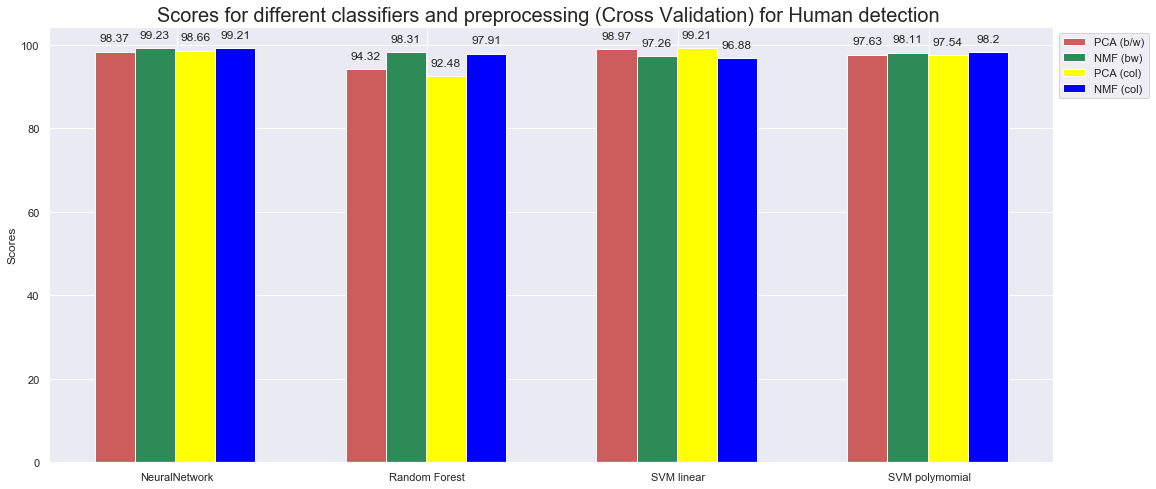

In [29]:
#Here, we just plot histogram to have a better visualisation of the 16 different models score.
#we can compare them quicker. This part is just for presentation and does not have influence on model implementation

sns.set()
def truncate(number, dec):
    return((int(number*(10**dec)))/(10.**dec))
    
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                    str(truncate(height, 2)),
                    ha='center', va='bottom')

        
        
human_pred_bw_PCA = 100 * np.array([c1_h_bw_PCA, c2_h_bw_PCA, c3_h_bw_PCA, c4_h_bw_PCA])
human_pred_bw_NMF = 100 * np.array([c1_h_bw_NMF, c2_h_bw_NMF, c3_h_bw_NMF, c4_h_bw_NMF])
human_pred_col_PCA = 100 * np.array([c1_h_col_PCA, c2_h_col_PCA, c3_h_col_PCA, c4_h_col_PCA])
human_pred_col_NMF = 100 * np.array([c1_h_col_NMF, c2_h_col_NMF, c3_h_col_NMF, c4_h_col_NMF])




width = 0.2
N = len(human_pred_bw_NMF)
ind = np.arange(N) * 1.25  # the x locations for the groups

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(ind, human_pred_bw_PCA, width, color='indianred')
rects2 = ax.bar(ind + width, human_pred_bw_NMF, width, color='seagreen')
rects3 = ax.bar(ind + 2*width, human_pred_col_PCA, width, color='yellow')
rects4 = ax.bar(ind + 3*width, human_pred_col_NMF, width, color='blue')
autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)
autolabel(rects4, ax)

ax.set_ylabel('Scores')
ax.set_title('Scores for different classifiers and preprocessing (Cross Validation) for Human detection ', fontsize = 20)
ax.set_xticks(ind + width / .65)
ax.set_xticklabels(('NeuralNetwork', 'Random Forest', 'SVM linear', 'SVM polymomial'))
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), 
          ('PCA (b/w)', 'NMF (bw)', 'PCA (col)', 'NMF (col)'), bbox_to_anchor=(1, 1))
plt.show()

### Young or old

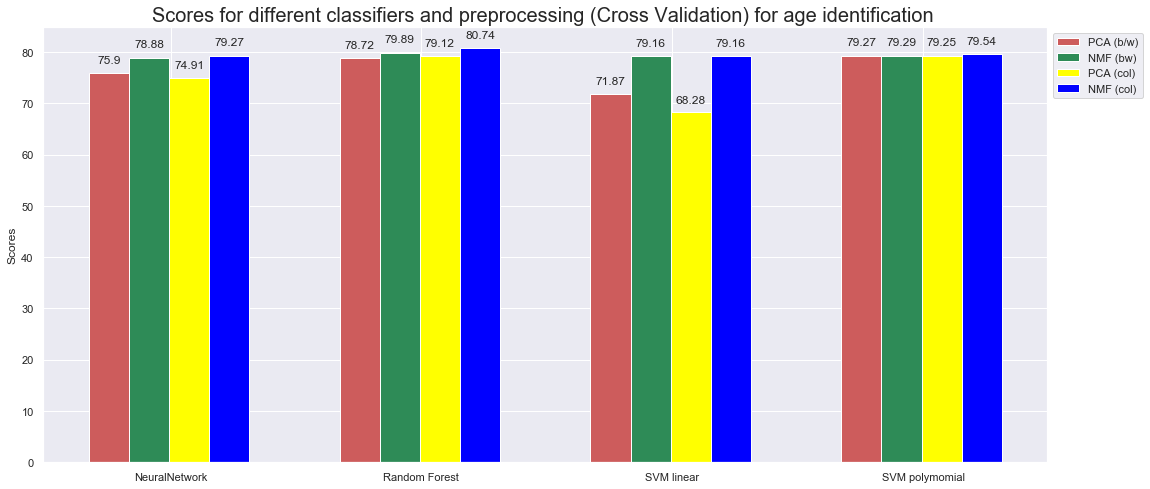

In [30]:
young_pred_bw_PCA = 100 * np.array([c1_y_bw_PCA, c2_y_bw_PCA, c3_y_bw_PCA, c4_y_bw_PCA])
young_pred_bw_NMF = 100 * np.array([c1_y_bw_NMF, c2_y_bw_NMF, c3_y_bw_NMF, c4_y_bw_NMF])
young_pred_col_PCA = 100 * np.array([c1_y_col_PCA, c2_y_col_PCA, c3_y_col_PCA, c4_y_col_PCA])
young_pred_col_NMF = 100 * np.array([c1_y_col_NMF, c2_y_col_NMF, c3_y_col_NMF, c4_y_col_NMF])




width = 0.2
N = len(young_pred_bw_NMF)
ind = np.arange(N) * 1.25  # the x locations for the groups

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(ind, young_pred_bw_PCA, width, color='indianred')
rects2 = ax.bar(ind + width, young_pred_bw_NMF, width, color='seagreen')
rects3 = ax.bar(ind + 2*width, young_pred_col_PCA, width, color='yellow')
rects4 = ax.bar(ind + 3*width, young_pred_col_NMF, width, color='blue')
autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)
autolabel(rects4, ax)

ax.set_ylabel('Scores')
ax.set_title('Scores for different classifiers and preprocessing (Cross Validation) for age identification ', fontsize = 20)
ax.set_xticks(ind + width / .65)
ax.set_xticklabels(('NeuralNetwork', 'Random Forest', 'SVM linear', 'SVM polymomial'))
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), 
          ('PCA (b/w)', 'NMF (bw)', 'PCA (col)', 'NMF (col)'), bbox_to_anchor=(1, 1))
plt.show()

### smiling

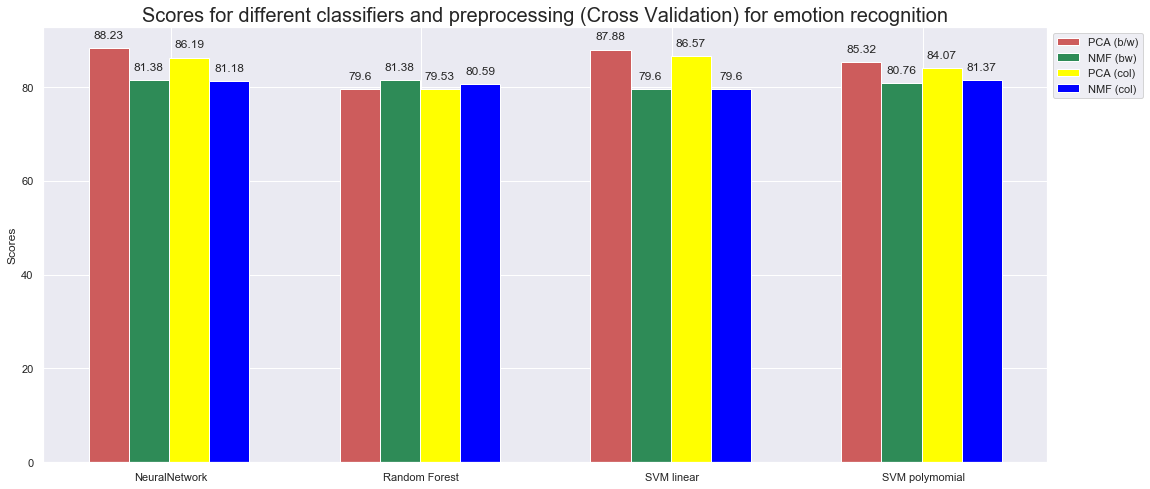

In [31]:
smiling_pred_bw_PCA = 100 * np.array([c1_s_bw_PCA, c2_s_bw_PCA, c3_s_bw_PCA, c4_s_bw_PCA])
smiling_pred_bw_NMF = 100 * np.array([c1_s_bw_NMF, c2_s_bw_NMF, c3_s_bw_NMF, c4_s_bw_NMF])
smiling_pred_col_PCA = 100 * np.array([c1_s_col_PCA, c2_s_col_PCA, c3_s_col_PCA, c4_s_col_PCA])
smiling_pred_col_NMF = 100 * np.array([c1_s_col_NMF, c2_s_col_NMF, c3_s_col_NMF, c4_s_col_NMF])




width = 0.2
N = len(smiling_pred_bw_NMF)
ind = np.arange(N) * 1.25  # the x locations for the groups

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(ind, smiling_pred_bw_PCA, width, color='indianred')
rects2 = ax.bar(ind + width, smiling_pred_bw_NMF, width, color='seagreen')
rects3 = ax.bar(ind + 2*width, smiling_pred_col_PCA, width, color='yellow')
rects4 = ax.bar(ind + 3*width, smiling_pred_col_NMF, width, color='blue')
autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)
autolabel(rects4, ax)

ax.set_ylabel('Scores')
ax.set_title('Scores for different classifiers and preprocessing (Cross Validation) for emotion recognition', fontsize = 20)
ax.set_xticks(ind + width / .65)
ax.set_xticklabels(('NeuralNetwork', 'Random Forest', 'SVM linear', 'SVM polymomial'))
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), 
          ('PCA (b/w)', 'NMF (bw)', 'PCA (col)', 'NMF (col)'), bbox_to_anchor=(1, 1))
plt.show()

### With or without eyeglasses

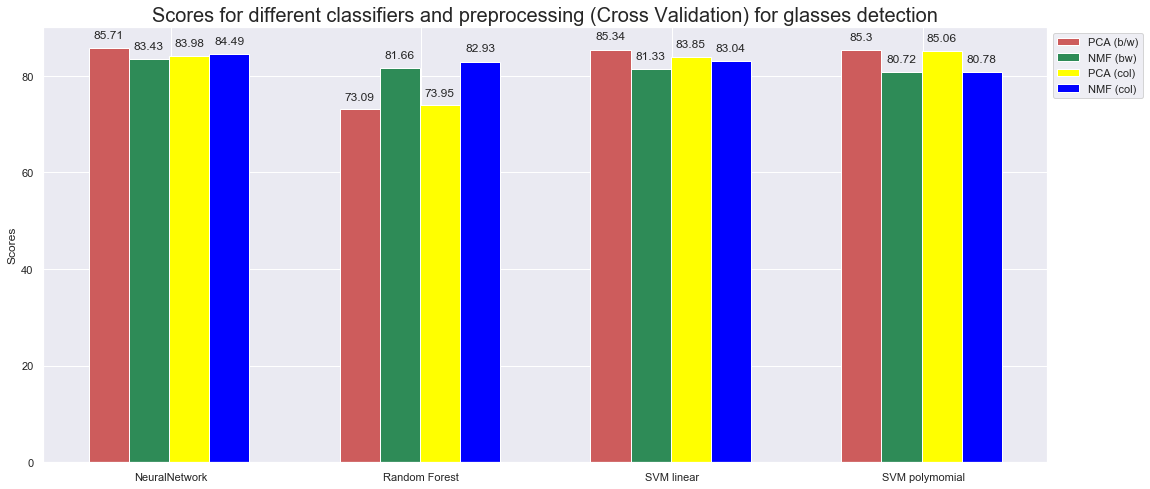

In [32]:
eyeglasses_pred_bw_PCA = 100 * np.array([c1_e_bw_PCA, c2_e_bw_PCA, c3_e_bw_PCA, c4_e_bw_PCA])
eyeglasses_pred_bw_NMF = 100 * np.array([c1_e_bw_NMF, c2_e_bw_NMF, c3_e_bw_NMF, c4_e_bw_NMF])
eyeglasses_pred_col_PCA = 100 * np.array([c1_e_col_PCA, c2_e_col_PCA, c3_e_col_PCA, c4_e_col_PCA])
eyeglasses_pred_col_NMF = 100 * np.array([c1_e_col_NMF, c2_e_col_NMF, c3_e_col_NMF, c4_e_col_NMF])




width = 0.2
N = len(eyeglasses_pred_bw_NMF)
ind = np.arange(N) * 1.25  # the x locations for the groups

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(ind, eyeglasses_pred_bw_PCA, width, color='indianred')
rects2 = ax.bar(ind + width, eyeglasses_pred_bw_NMF, width, color='seagreen')
rects3 = ax.bar(ind + 2*width, eyeglasses_pred_col_PCA, width, color='yellow')
rects4 = ax.bar(ind + 3*width, eyeglasses_pred_col_NMF, width, color='blue')
autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)
autolabel(rects4, ax)

ax.set_ylabel('Scores')
ax.set_title('Scores for different classifiers and preprocessing (Cross Validation) for glasses detection', fontsize = 20)
ax.set_xticks(ind + width / .65)
ax.set_xticklabels(('NeuralNetwork', 'Random Forest', 'SVM linear', 'SVM polymomial'))
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), 
          ('PCA (b/w)', 'NMF (bw)', 'PCA (col)', 'NMF (col)'), bbox_to_anchor=(1, 1))
plt.show()

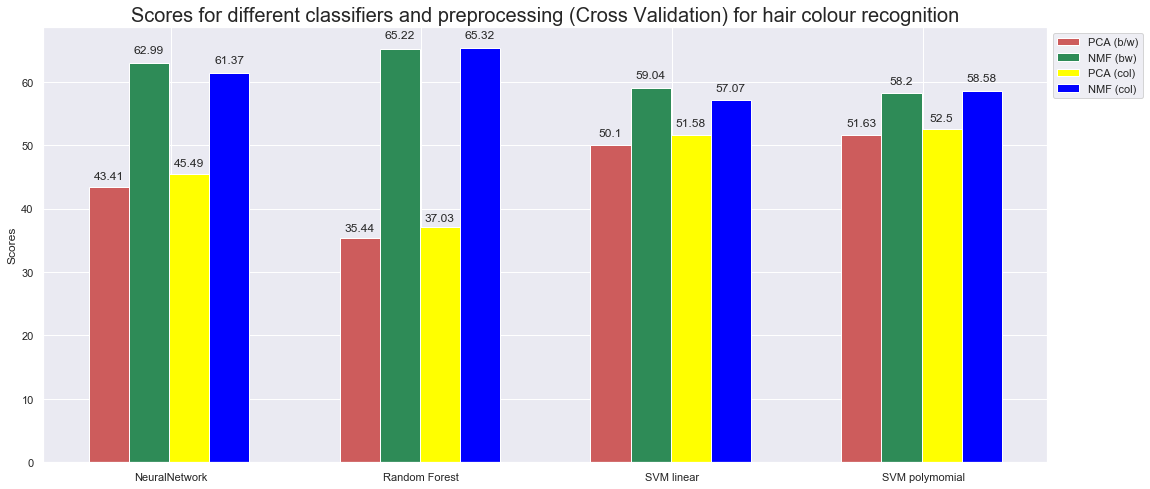

In [33]:
hair_pred_bw_PCA = 100 * np.array([c1_hair_bw_PCA, c2_hair_bw_PCA, c3_hair_bw_PCA, c4_hair_bw_PCA])
hair_pred_bw_NMF = 100 * np.array([c1_hair_bw_NMF, c2_hair_bw_NMF, c3_hair_bw_NMF, c4_hair_bw_NMF])
hair_pred_col_PCA = 100 * np.array([c1_hair_col_PCA, c2_hair_col_PCA, c3_hair_col_PCA, c4_hair_col_PCA])
hair_pred_col_NMF = 100 * np.array([c1_hair_col_NMF, c2_hair_col_NMF, c3_hair_col_NMF, c4_hair_col_NMF])




width = 0.2
N = len(hair_pred_bw_NMF)
ind = np.arange(N) * 1.25  # the x locations for the groups

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(ind, hair_pred_bw_PCA, width, color='indianred')
rects2 = ax.bar(ind + width, hair_pred_bw_NMF, width, color='seagreen')
rects3 = ax.bar(ind + 2*width, hair_pred_col_PCA, width, color='yellow')
rects4 = ax.bar(ind + 3*width, hair_pred_col_NMF, width, color='blue')
autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)
autolabel(rects4, ax)

ax.set_ylabel('Scores')
ax.set_title('Scores for different classifiers and preprocessing (Cross Validation) for hair colour recognition', fontsize = 20)
ax.set_xticks(ind + width / .65)
ax.set_xticklabels(('NeuralNetwork', 'Random Forest', 'SVM linear', 'SVM polymomial'))
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), 
          ('PCA (b/w)', 'NMF (bw)', 'PCA (col)', 'NMF (col)'), bbox_to_anchor=(1, 1))
plt.show()

# Human detection: create, train and test model

In [50]:
t = time.time()
# our model is actually a voting result taking into account 5 models which have the same classifier type
# but which are trained and tested with different data (either original or randomly transformed)

# The max voting method is generally used for classification problems (that the one we are using). In this technique, 
# multiple models are used to make predictions for each data point. The predictions by each
# model are considered as a ‘vote’. The predictions which we get from the majority of the models 
# are used as the final prediction.


# Note, we split data once as the function'createSets' randomly return smpl and indM. 
# So, as we want to train the models with data organized in the same order (so they return predictions 
# for the same picture at the same time), we use the same spliting but apply it to different data

# Training different models on different set of data unsure that each model might have identify 
# different partern in order to recognize an element (human, glasses, emotion or age). 
# Hence, we limit the risk of overfitting without the need of new dataset






Y_human = np.array(df['human'])

# Various splitting and naming
smpl, indM = createSets(file_name_binary_bw)
names_for_train, names_for_test = smpl[:indM], smpl[indM:]

# Verification step: confirm that data set has been splited correctly
print(names_for_train.shape, names_for_test.shape, names_for_train.shape[0] + names_for_test.shape[0])

###################################### model with original data #########################################



X_train_h, X_test_h = X_binary_bw_NMF[names_for_train], X_binary_bw_NMF[names_for_test]
Y_train_h, Y_test_h = Y_human[names_for_train], Y_human[names_for_test]


# Verification step
print(X_train_h.shape, X_test_h.shape, X_train_h.shape[0] + X_test_h.shape[0])

# Create and train model
clf_neuralNetwork_human = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_human.fit(X_train_h, Y_train_h)



# Get model score and test it (do predictions)
score_h = clf_neuralNetwork_human.score(X_test_h, Y_test_h)
predictions_human = clf_neuralNetwork_human.predict(X_test_h)


###################################### model 1 with transformed data #########################################


X_train_h_trans1, X_test_h_trans1 = X_binary_bw_NMF_trans1[names_for_train], X_binary_bw_NMF_trans1[names_for_test]
Y_train_h_trans1, Y_test_h_trans1 = Y_human[names_for_train], Y_human[names_for_test]


# Verification step
print(X_train_h_trans1.shape, X_test_h_trans1.shape, X_train_h_trans1.shape[0] + X_test_h_trans1.shape[0])

# Create and train model
clf_neuralNetwork_human_trans1 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_human_trans1.fit(X_train_h_trans1, Y_train_h_trans1)

# Get model score and test it (do predictions)
score_trans1_h = clf_neuralNetwork_human_trans1.score(X_test_h_trans1, Y_test_h_trans1)
predictions_human_trans1 = clf_neuralNetwork_human_trans1.predict(X_test_h_trans1)


###################################### model 2 with transformed data #########################################



X_train_h_trans2, X_test_h_trans2 = X_binary_bw_NMF_trans2[names_for_train], X_binary_bw_NMF_trans2[names_for_test]
Y_train_h_trans2, Y_test_h_trans2 = Y_human[names_for_train], Y_human[names_for_test]


# Verification step
print(X_train_h_trans2.shape, X_test_h_trans2.shape, X_train_h_trans2.shape[0] + X_test_h_trans2.shape[0])

# Create and train model
clf_neuralNetwork_human_trans2 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_human_trans2.fit(X_train_h_trans2, Y_train_h_trans2)

# Get model score and test it (do predictions)
score_trans2_h = clf_neuralNetwork_human_trans2.score(X_test_h_trans2, Y_test_h_trans2)
predictions_human_trans2 = clf_neuralNetwork_human_trans2.predict(X_test_h_trans2)




###################################### model 3 with transformed data #########################################



X_train_h_trans3, X_test_h_trans3 = X_binary_bw_NMF_trans3[names_for_train], X_binary_bw_NMF_trans3[names_for_test]
Y_train_h_trans3, Y_test_h_trans3 = Y_human[names_for_train], Y_human[names_for_test]


# Verification step
print(X_train_h_trans3.shape, X_test_h_trans3.shape, X_train_h_trans3.shape[0] + X_test_h_trans3.shape[0])

# Create and train model
clf_neuralNetwork_human_trans3 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_human_trans3.fit(X_train_h_trans3, Y_train_h_trans3)

# Get model score and test it (do predictions)
score_trans3_h = clf_neuralNetwork_human_trans3.score(X_test_h_trans3, Y_test_h_trans3)
predictions_human_trans3 = clf_neuralNetwork_human_trans3.predict(X_test_h_trans3)


###################################### model 4 with transformed data #########################################

X_train_h_trans4, X_test_h_trans4 = X_binary_bw_NMF_trans4[names_for_train], X_binary_bw_NMF_trans4[names_for_test]
Y_train_h_trans4, Y_test_h_trans4 = Y_human[names_for_train], Y_human[names_for_test]


# Verification step
print(X_train_h_trans4.shape, X_test_h_trans4.shape, X_train_h_trans4.shape[0] + X_test_h_trans4.shape[0])

# Create and train model
clf_neuralNetwork_human_trans4 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_human_trans4.fit(X_train_h_trans4, Y_train_h_trans4)

# Get model score and test it (do predictions)
score_trans4_h = clf_neuralNetwork_human_trans4.score(X_test_h_trans4, Y_test_h_trans4)
predictions_human_trans4 = clf_neuralNetwork_human_trans4.predict(X_test_h_trans4)




############################################# final prediction ###################################################

# number total of prediction is odd: so we avoir too have equal
# predictions for 0 and 1: we would be uncapable to determine a final solution
# the function mode returns the prediction number that has been generated the most number of times. 

final_pred_h = np.array([])
for i in range(0,len(X_test_h)):
    final_pred_h = np.append(final_pred_h, mode([predictions_human[i], predictions_human_trans1[i], predictions_human_trans2[i], predictions_human_trans3[i], predictions_human_trans4[i]]))


# final score is caculated by taking the sum of elements of the confusion matrice diagonal 
# (they are the one that has been correctly predicted) and divide it by the sum of every element 
# of the confusion matrice (total number of predictoon. We multipy by 100 to get percentage)
    
cnf_matrix_h = confusion_matrix(Y_test_h, final_pred_h)
print('')
print('confusion matrix for human: ')
print('')
print(cnf_matrix_h)
print('')
final_score_h = (cnf_matrix_h.item(0) + cnf_matrix_h.item(3))*100/(cnf_matrix_h.item(0)+cnf_matrix_h.item(1)+cnf_matrix_h.item(2)+cnf_matrix_h.item(3))



########################################### Export data to .cvs ######################################

#d defines the way we want to present data in csv file

d = {'X test (file name)': [str(names_for_test[k])+'.png' for k in range(len(names_for_test))], 'Y predicted': final_pred_h}
df_exp = pd.DataFrame(data=d)
print('Score of classifier:', final_score_h)


print(df_exp.shape)

df_exp.loc[-1] = [str(final_score_h), np.nan]
df_exp.index = df_exp.index + 1
df_exp = df_exp.sort_index()  # sorting by index

print(df_exp.shape)
df_exp.to_csv(path_or_buf='Human detection_4.csv', header=False, index=False)




print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')


(3804,) (761,) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565

confusion matrix for human: 

[[421   1]
 [212 127]]

Score of classifier: 72.01051248357425
(761, 2)
(762, 2)
Time to compute this part: 0.16 min


# Age identification: create, train and test model

In [51]:
t = time.time()
# our model is actually a voting result taking into account 5 models which have the same classifier type
# but which are trained and tested with different data (either original or randomly transformed)

# The max voting method is generally used for classification problems (that the one we are using). In this technique, 
# multiple models are used to make predictions for each data point. The predictions by each
# model are considered as a ‘vote’. The predictions which we get from the majority of the models 
# are used as the final prediction.


# Note, we split data once as the function'createSets' randomly return smpl and indM. 
# So, as we want to train the models with data organized in the same order (so they return predictions 
# for the same picture at the same time), we use the same spliting but apply it to different data

# Training different models on different set of data unsure that each model might have identify 
# different partern in order to recognize an element (human, glasses, emotion or age). 
# Hence, we limit the risk of overfitting without the need of new dataset




Y_young = np.array(df['young'])

# Various splitting and naming
smpl, indM = createSets(file_name_binary_bw)
names_for_train, names_for_test = smpl[:indM], smpl[indM:]

# Verification step: confirm that data set has been splited correctly
print(names_for_train.shape, names_for_test.shape, names_for_train.shape[0] + names_for_test.shape[0])

###################################### model with original data #########################################



X_train_y, X_test_y = X_binary_bw_NMF[names_for_train], X_binary_bw_NMF[names_for_test]
Y_train_y, Y_test_y = Y_young[names_for_train], Y_young[names_for_test]


# Verification step
print(X_train_h.shape, X_test_h.shape, X_train_h.shape[0] + X_test_h.shape[0])

# Create and train model
clf_neuralNetwork_young = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_young.fit(X_train_y, Y_train_y)



# Get model score and test it (do predictions)
score_y = clf_neuralNetwork_young.score(X_test_y, Y_test_y)
predictions_young = clf_neuralNetwork_young.predict(X_test_y)


###################################### model 1 with transformed data #########################################


X_train_y_trans1, X_test_y_trans1 = X_binary_bw_NMF_trans1[names_for_train], X_binary_bw_NMF_trans1[names_for_test]
Y_train_y_trans1, Y_test_y_trans1 = Y_young[names_for_train], Y_young[names_for_test]


# Verification step
print(X_train_y_trans1.shape, X_test_y_trans1.shape, X_train_y_trans1.shape[0] + X_test_y_trans1.shape[0])

# Create and train model
clf_neuralNetwork_young_trans1 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_young_trans1.fit(X_train_y_trans1, Y_train_y_trans1)

# Get model score and test it (do predictions)
score_trans1_y = clf_neuralNetwork_young_trans1.score(X_test_y_trans1, Y_test_y_trans1)
predictions_young_trans1 = clf_neuralNetwork_young_trans1.predict(X_test_y_trans1)


###################################### model 2 with transformed data #########################################



X_train_y_trans2, X_test_y_trans2 = X_binary_bw_NMF_trans2[names_for_train], X_binary_bw_NMF_trans2[names_for_test]
Y_train_y_trans2, Y_test_y_trans2 = Y_young[names_for_train], Y_young[names_for_test]


# Verification step
print(X_train_y_trans2.shape, X_test_y_trans2.shape, X_train_y_trans2.shape[0] + X_test_y_trans2.shape[0])

# Create and train model
clf_neuralNetwork_young_trans2 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_young_trans2.fit(X_train_y_trans2, Y_train_y_trans2)

# Get model score and test it (do predictions)
score_trans2_y = clf_neuralNetwork_young_trans2.score(X_test_y_trans2, Y_test_y_trans2)
predictions_young_trans2 = clf_neuralNetwork_young_trans2.predict(X_test_y_trans2)




###################################### model 3 with transformed data #########################################



X_train_y_trans3, X_test_y_trans3 = X_binary_bw_NMF_trans3[names_for_train], X_binary_bw_NMF_trans3[names_for_test]
Y_train_y_trans3, Y_test_y_trans3 = Y_young[names_for_train], Y_young[names_for_test]


# Verification step
print(X_train_y_trans3.shape, X_test_y_trans3.shape, X_train_y_trans3.shape[0] + X_test_y_trans3.shape[0])

# Create and train model
clf_neuralNetwork_young_trans3 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_young_trans3.fit(X_train_y_trans3, Y_train_y_trans3)

# Get model score and test it (do predictions)
score_trans3_y = clf_neuralNetwork_young_trans3.score(X_test_y_trans3, Y_test_y_trans3)
predictions_young_trans3 = clf_neuralNetwork_young_trans3.predict(X_test_y_trans3)


###################################### model 4 with transformed data #########################################

X_train_y_trans4, X_test_y_trans4 = X_binary_bw_NMF_trans4[names_for_train], X_binary_bw_NMF_trans4[names_for_test]
Y_train_y_trans4, Y_test_y_trans4 = Y_young[names_for_train], Y_young[names_for_test]


# Verification step
print(X_train_y_trans4.shape, X_test_y_trans4.shape, X_train_y_trans4.shape[0] + X_test_y_trans4.shape[0])

# Create and train model
clf_neuralNetwork_young_trans4 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_young_trans4.fit(X_train_y_trans4, Y_train_y_trans4)

# Get model score and test it (do predictions)
score_trans4_y = clf_neuralNetwork_young_trans4.score(X_test_y_trans4, Y_test_y_trans4)
predictions_young_trans4 = clf_neuralNetwork_young_trans4.predict(X_test_y_trans4)




############################################# final prediction ###################################################

# number total of prediction is odd: so we avoir too have equal predictions for 0 and 1: 
# we would be uncapable to determine a final solution

final_pred_y = np.array([])
for i in range(0,len(X_test_y)):
    final_pred_y = np.append(final_pred_y, mode([predictions_young[i], predictions_young_trans1[i], predictions_young_trans2[i], predictions_young_trans3[i], predictions_young_trans4[i]]))

# final score is caculated by taking the sum of elements of the confusion matrice diagonal 
# (they are the one that has been correctly predicted) and divide it by the sum of every element 
# of the confusion matrice (total number of predictoon. We multipy by 100 to get percentage)

cnf_matrix_y = confusion_matrix(Y_test_y, final_pred_y)
print('')
print('confusion matrix for age detection: ')
print('')
print(cnf_matrix_y)
print('')
final_score_y = (cnf_matrix_y.item(0) + cnf_matrix_y.item(3))*100/(cnf_matrix_y.item(0)+cnf_matrix_y.item(1)+cnf_matrix_y.item(2)+cnf_matrix_y.item(3))




########################################### Export data to .cvs ######################################

#d defines the way we want to present data in csv file

d = {'X test (file name)': [str(names_for_test[k])+'.png' for k in range(len(names_for_test))], 'Y predicted': final_pred_y}
df_exp = pd.DataFrame(data=d)
print('Score of classifier:', final_score_y)


print(df_exp.shape)

df_exp.loc[-1] = [str(final_score_y), np.nan]
df_exp.index = df_exp.index + 1
df_exp = df_exp.sort_index()  # sorting by index

print(df_exp.shape)
df_exp.to_csv(path_or_buf='Age identification_2.csv', header=False, index=False)


print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')


(3804,) (761,) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565

confusion matrix for age detection: 

[[  6 145]
 [  5 605]]

Score of classifier: 80.28909329829172
(761, 2)
(762, 2)
Time to compute this part: 0.17 min


# Emotion recognition: create, train and test model

In [54]:
t = time.time()
# our model is actually a voting result taking into account 5 models which have the same classifier type
# but which are trained and tested with different data (either original or randomly transformed)

# The max voting method is generally used for classification problems (that the one we are using). In this technique, 
# multiple models are used to make predictions for each data point. The predictions by each
# model are considered as a ‘vote’. The predictions which we get from the majority of the models 
# are used as the final prediction.


# Note, we split data once as the function'createSets' randomly return smpl and indM. 
# So, as we want to train the models with data organized in the same order (so they return predictions 
# for the same picture at the same time), we use the same spliting but apply it to different data

# Training different models on different set of data unsure that each model might have identify 
# different partern in order to recognize an element (human, glasses, emotion or age). 
# Hence, we limit the risk of overfitting without the need of new dataset


Y_smiling = np.array(df['smiling'])

# Various splitting and naming
smpl, indM = createSets(file_name_binary_bw)
names_for_train, names_for_test = smpl[:indM], smpl[indM:]

# Verification step: confirm that data set has been splited correctly
print(names_for_train.shape, names_for_test.shape, names_for_train.shape[0] + names_for_test.shape[0])

###################################### model with original data #########################################



X_train_s, X_test_s = X_binary_bw_NMF[names_for_train], X_binary_bw_NMF[names_for_test]
Y_train_s, Y_test_s = Y_smiling[names_for_train], Y_smiling[names_for_test]


# Verification step
print(X_train_s.shape, X_test_s.shape, X_train_s.shape[0] + X_test_s.shape[0])

# Create and train model
clf_neuralNetwork_smiling = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_smiling.fit(X_train_s, Y_train_s)



# Get model score and test it (do predictions)
score_s = clf_neuralNetwork_smiling.score(X_test_s, Y_test_s)
predictions_smiling = clf_neuralNetwork_smiling.predict(X_test_s)


###################################### model 1 with transformed data #########################################


X_train_s_trans1, X_test_s_trans1 = X_binary_bw_NMF_trans1[names_for_train], X_binary_bw_NMF_trans1[names_for_test]
Y_train_s_trans1, Y_test_s_trans1 = Y_smiling[names_for_train], Y_smiling[names_for_test]


# Verification step
print(X_train_s_trans1.shape, X_test_s_trans1.shape, X_train_s_trans1.shape[0] + X_test_s_trans1.shape[0])

# Create and train model
clf_neuralNetwork_smiling_trans1 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_smiling_trans1.fit(X_train_s_trans1, Y_train_s_trans1)

# Get model score and test it (do predictions)
score_trans1_s = clf_neuralNetwork_smiling_trans1.score(X_test_s_trans1, Y_test_s_trans1)
predictions_smiling_trans1 = clf_neuralNetwork_smiling_trans1.predict(X_test_s_trans1)


###################################### model 2 with transformed data #########################################



X_train_s_trans2, X_test_s_trans2 = X_binary_bw_NMF_trans2[names_for_train], X_binary_bw_NMF_trans2[names_for_test]
Y_train_s_trans2, Y_test_s_trans2 = Y_smiling[names_for_train], Y_smiling[names_for_test]


# Verification step
print(X_train_s_trans2.shape, X_test_s_trans2.shape, X_train_s_trans2.shape[0] + X_test_s_trans2.shape[0])

# Create and train model
clf_neuralNetwork_smiling_trans2 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_smiling_trans2.fit(X_train_s_trans2, Y_train_s_trans2)

# Get model score and test it (do predictions)
score_trans2_s = clf_neuralNetwork_smiling_trans2.score(X_test_s_trans2, Y_test_s_trans2)
predictions_smiling_trans2 = clf_neuralNetwork_smiling_trans2.predict(X_test_s_trans2)




###################################### model 3 with transformed data #########################################



X_train_s_trans3, X_test_s_trans3 = X_binary_bw_NMF_trans3[names_for_train], X_binary_bw_NMF_trans3[names_for_test]
Y_train_s_trans3, Y_test_s_trans3 = Y_smiling[names_for_train], Y_smiling[names_for_test]


# Verification step
print(X_train_s_trans3.shape, X_test_s_trans3.shape, X_train_s_trans3.shape[0] + X_test_s_trans3.shape[0])

# Create and train model
clf_neuralNetwork_smiling_trans3 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_smiling_trans3.fit(X_train_s_trans3, Y_train_s_trans3)

# Get model score and test it (do predictions)
score_trans3_s = clf_neuralNetwork_smiling_trans3.score(X_test_s_trans3, Y_test_s_trans3)
predictions_smiling_trans3 = clf_neuralNetwork_smiling_trans3.predict(X_test_s_trans3)


###################################### model 4 with transformed data #########################################

X_train_s_trans4, X_test_s_trans4 = X_binary_bw_NMF_trans4[names_for_train], X_binary_bw_NMF_trans4[names_for_test]
Y_train_s_trans4, Y_test_s_trans4 = Y_smiling[names_for_train], Y_smiling[names_for_test]


# Verification step
print(X_train_s_trans4.shape, X_test_s_trans4.shape, X_train_s_trans4.shape[0] + X_test_s_trans4.shape[0])

# Create and train model
clf_neuralNetwork_smiling_trans4 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_smiling_trans4.fit(X_train_s_trans4, Y_train_s_trans4)

# Get model score and test it (do predictions)
score_trans4_s = clf_neuralNetwork_smiling_trans4.score(X_test_s_trans4, Y_test_s_trans4)
predictions_smiling_trans4 = clf_neuralNetwork_smiling_trans4.predict(X_test_s_trans4)




############################################# final prediction ###################################################

# number total of prediction is odd: so we avoir too have equal predictions for 0 and 1:
# we would be uncapable to determine a final solution

final_pred_s = np.array([])
for i in range(0,len(X_test_s)):
    final_pred_s = np.append(final_pred_s, mode([predictions_smiling[i], predictions_smiling_trans1[i], predictions_smiling_trans2[i], predictions_smiling_trans3[i], predictions_smiling_trans4[i]]))

# final score is caculated by taking the sum of elements of the confusion matrice diagonal 
# (they are the one that has been correctly predicted) and divide it by the sum of every element 
# of the confusion matrice (total number of predictoon. We multipy by 100 to get percentage)

cnf_matrix_s = confusion_matrix(Y_test_s, final_pred_s)
print('')
print('confusion matrix for emotion recognition: ')
print('')
print(cnf_matrix_s)
print('')
final_score_s = (cnf_matrix_s.item(0) + cnf_matrix_s.item(3))*100/(cnf_matrix_s.item(0)+cnf_matrix_s.item(1)+cnf_matrix_s.item(2)+cnf_matrix_s.item(3))




########################################### Export data to .cvs ######################################
#d defines the way we want to present data in csv file

d = {'X test (file name)': [str(names_for_test[k])+'.png' for k in range(len(names_for_test))], 'Y predicted': final_pred_s}
df_exp = pd.DataFrame(data=d)
print('Score of classifier:', final_score_s)


print(df_exp.shape)

df_exp.loc[-1] = [str(final_score_s), np.nan]
df_exp.index = df_exp.index + 1
df_exp = df_exp.sort_index()  # sorting by index
print(df_exp.shape)
df_exp.to_csv(path_or_buf='Emotion recognition_1.csv', header=False, index=False)


print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')

(3804,) (761,) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565

confusion matrix for emotion recognition: 

[[ 17 143]
 [ 17 584]]

Score of classifier: 78.97503285151117
(761, 2)
(762, 2)
Time to compute this part: 0.2 min


# Glasses: create, train and test model

In [52]:
t = time.time()

# our model is actually a voting result taking into account 5 models which have the same classifier type
# but which are trained and tested with different data (either original or randomly transformed)

# The max voting method is generally used for classification problems (that the one we are using). In this technique, 
# multiple models are used to make predictions for each data point. The predictions by each
# model are considered as a ‘vote’. The predictions which we get from the majority of the models 
# are used as the final prediction.


# Note, we split data once as the function'createSets' randomly return smpl and indM. 
# So, as we want to train the models with data organized in the same order (so they return predictions 
# for the same picture at the same time), we use the same spliting but apply it to different data

# Training different models on different set of data unsure that each model might have identify 
# different partern in order to recognize an element (human, glasses, emotion or age). 
# Hence, we limit the risk of overfitting without the need of new dataset




Y_eyeglasses = np.array(df['eyeglasses'])

# Various splitting and naming
smpl, indM = createSets(file_name_binary_bw)
names_for_train, names_for_test = smpl[:indM], smpl[indM:]

# Verification step: confirm that data set has been splited correctly
print(names_for_train.shape, names_for_test.shape, names_for_train.shape[0] + names_for_test.shape[0])

###################################### model with original data #########################################



X_train_e, X_test_e = X_binary_bw_NMF[names_for_train], X_binary_bw_NMF[names_for_test]
Y_train_e, Y_test_e = Y_eyeglasses[names_for_train], Y_eyeglasses[names_for_test]


# Verification step
print(X_train_e.shape, X_test_e.shape, X_train_e.shape[0] + X_test_e.shape[0])

# Create and train model
clf_neuralNetwork_eyeglasses = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_eyeglasses.fit(X_train_e, Y_train_e)



# Get model score and test it (do predictions)
score_e = clf_neuralNetwork_eyeglasses.score(X_test_e, Y_test_e)
predictions_eyeglasses = clf_neuralNetwork_eyeglasses.predict(X_test_e)


###################################### model 1 with transformed data #########################################


X_train_e_trans1, X_test_e_trans1 = X_binary_bw_NMF_trans1[names_for_train], X_binary_bw_NMF_trans1[names_for_test]
Y_train_e_trans1, Y_test_e_trans1 = Y_eyeglasses[names_for_train], Y_eyeglasses[names_for_test]


# Verification step
print(X_train_e_trans1.shape, X_test_e_trans1.shape, X_train_e_trans1.shape[0] + X_test_e_trans1.shape[0])

# Create and train model
clf_neuralNetwork_eyeglasses_trans1 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_eyeglasses_trans1.fit(X_train_e_trans1, Y_train_e_trans1)

# Get model score and test it (do predictions)
score_trans1_e = clf_neuralNetwork_eyeglasses_trans1.score(X_test_e_trans1, Y_test_e_trans1)
predictions_eyeglasses_trans1 = clf_neuralNetwork_eyeglasses_trans1.predict(X_test_e_trans1)


###################################### model 2 with transformed data #########################################



X_train_e_trans2, X_test_e_trans2 = X_binary_bw_NMF_trans2[names_for_train], X_binary_bw_NMF_trans2[names_for_test]
Y_train_e_trans2, Y_test_e_trans2 = Y_eyeglasses[names_for_train], Y_eyeglasses[names_for_test]


# Verification step
print(X_train_e_trans2.shape, X_test_e_trans2.shape, X_train_e_trans2.shape[0] + X_test_e_trans2.shape[0])

# Create and train model
clf_neuralNetwork_eyeglasses_trans2 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_eyeglasses_trans2.fit(X_train_e_trans2, Y_train_e_trans2)

# Get model score and test it (do predictions)
score_trans2_e = clf_neuralNetwork_eyeglasses_trans2.score(X_test_e_trans2, Y_test_e_trans2)
predictions_eyeglasses_trans2 = clf_neuralNetwork_eyeglasses_trans2.predict(X_test_e_trans2)




###################################### model 3 with transformed data #########################################



X_train_e_trans3, X_test_e_trans3 = X_binary_bw_NMF_trans3[names_for_train], X_binary_bw_NMF_trans3[names_for_test]
Y_train_e_trans3, Y_test_e_trans3 = Y_eyeglasses[names_for_train], Y_eyeglasses[names_for_test]


# Verification step
print(X_train_e_trans3.shape, X_test_e_trans3.shape, X_train_e_trans3.shape[0] + X_test_e_trans3.shape[0])

# Create and train model
clf_neuralNetwork_eyeglasses_trans3 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_eyeglasses_trans3.fit(X_train_e_trans3, Y_train_e_trans3)

# Get model score and test it (do predictions)
score_trans3_e = clf_neuralNetwork_eyeglasses_trans3.score(X_test_e_trans3, Y_test_e_trans3)
predictions_eyeglasses_trans3 = clf_neuralNetwork_eyeglasses_trans3.predict(X_test_e_trans3)


###################################### model 4 with transformed data #########################################

X_train_e_trans4, X_test_e_trans4 = X_binary_bw_NMF_trans4[names_for_train], X_binary_bw_NMF_trans4[names_for_test]
Y_train_e_trans4, Y_test_e_trans4 = Y_eyeglasses[names_for_train], Y_eyeglasses[names_for_test]


# Verification step
print(X_train_e_trans4.shape, X_test_e_trans4.shape, X_train_e_trans4.shape[0] + X_test_e_trans4.shape[0])

# Create and train model
clf_neuralNetwork_eyeglasses_trans4 = MLPClassifier() # we take the classifier that got best cross validation score in the comparasion graph
clf_neuralNetwork_eyeglasses_trans4.fit(X_train_e_trans4, Y_train_e_trans4)

# Get model score and test it (do predictions)
score_trans4_e = clf_neuralNetwork_eyeglasses_trans4.score(X_test_e_trans4, Y_test_e_trans4)
predictions_eyeglasses_trans4 = clf_neuralNetwork_eyeglasses_trans4.predict(X_test_e_trans4)




############################################# final prediction ###################################################

# number total of prediction is odd: so we avoir too have equal predictions for 0 and 1: 
# we would be uncapable to determine a final solution

final_pred_e = np.array([])
for i in range(0,len(X_test_e)):
    final_pred_e = np.append(final_pred_e, mode([predictions_eyeglasses[i], predictions_eyeglasses_trans1[i], predictions_eyeglasses_trans2[i], predictions_eyeglasses_trans3[i], predictions_eyeglasses_trans4[i]]))

# final score is caculated by taking the sum of elements of the confusion matrice diagonal 
# (they are the one that has been correctly predicted) and divide it by the sum of every element 
# of the confusion matrice (total number of predictoon. We multipy by 100 to get percentage)

cnf_matrix_e = confusion_matrix(Y_test_e, final_pred_e)
print('')
print('confusion matrix for glasses detection: ')
print('')
print(cnf_matrix_e)
print('')
final_score_e = (cnf_matrix_e.item(0) + cnf_matrix_e.item(3))*100/(cnf_matrix_e.item(0)+cnf_matrix_e.item(1)+cnf_matrix_e.item(2)+cnf_matrix_e.item(3))




########################################### Export data to .cvs ######################################

#d defines the way we want to present data in csv file
d = {'X test (file name)': [str(names_for_test[k])+'.png' for k in range(len(names_for_test))], 'Y predicted': final_pred_e}
df_exp = pd.DataFrame(data=d)
print('Score of classifier:', final_score_e)


print(df_exp.shape)

df_exp.loc[-1] = [str(final_score_e), np.nan]
df_exp.index = df_exp.index + 1
df_exp = df_exp.sort_index()  # sorting by index
print(df_exp.shape)
df_exp.to_csv(path_or_buf='Glasses detection_3.csv', header=False, index=False)

print('Time to compute this part: ' + str(int(100*(time.time() - t)/60)/100) + ' min')

(3804,) (761,) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565
(3804, 15) (761, 15) 4565

confusion matrix for glasses detection: 

[[526   6]
 [173  56]]

Score of classifier: 76.47831800262811
(761, 2)
(762, 2)
Time to compute this part: 0.14 min


# Hair Color: create, train and test model

In [53]:
# For hair color, the system implemented is different. Here, we use 2 different models implemented with 
# 2 differents ML algorithm of same accuracy (IMPORTANT that acurrancies are similar). 
# Then we use the pre-built function Voting Classifier in order to train and test models. This 
# function will automatically return the prediction that has been made the highest number of time


# We used this approach as the previous one can not be able on multiclass task: 
# The probability to get equal number of a certain prediction is high and hence the 
# mode function would not have been able to return the max prediction in the vast majority of cases

# Various splitting and naming
smpl, indM = createSets(file_name_hair_bw)
names_for_train, names_for_test = smpl[:indM], smpl[indM:]

# Verification step: confirm that data set has been splited correctly
print(names_for_train.shape, names_for_test.shape, names_for_train.shape[0] + names_for_test.shape[0])

X_train_hair, X_test_hair = X_hair_bw_NMF[names_for_train], X_hair_bw_NMF[names_for_test]
Y_train_hair, Y_test_hair = Y_hair[names_for_train], Y_hair[names_for_test]

#create the 2 models that will be used for the voting part. We took the 2 best performing models 
#when NMF and B&W pre-processing are being used

model_1 = MLPClassifier()
model_2 = RandomForestClassifier(n_estimators=2000, criterion='gini')


model_hair = VotingClassifier(estimators=[('MLPC', model_1), ('RFC', model_2)], voting='hard')
model_hair.fit(X_train_hair, Y_train_hair)
final_score_hair = model_hair.score(X_test_hair, Y_test_hair)
predictions_hair = model_hair.predict(X_test_hair)


cnf_matrix_hair = confusion_matrix(Y_test_hair, predictions_hair)
print('')
print('confusion matrix for hair color: ')
print('')
print(cnf_matrix_hair)
print('')


########################################### Export data to .cvs ######################################

#d defines the way we want to present data in csv file

d = {'X test (file name)': [str(names_for_test[k])+'.png' for k in range(len(names_for_test))], 'Y predicted': predictions_hair}
df_exp = pd.DataFrame(data=d)
print('Score of classifier:', final_score_hair)


print(df_exp.shape)

df_exp.loc[-1] = [str(final_score_hair), np.nan]
df_exp.index = df_exp.index + 1
df_exp = df_exp.sort_index()  # sorting by index
print(df_exp.shape)
df_exp.to_csv(path_or_buf='Hair colour recognition_5.csv', header=False, index=False)

print('finished')


(3251,) (651,) 3902

confusion matrix for hair color: 

[[  4   5   2   3   0   2]
 [  2 136  11   7   0   8]
 [  0  13  68  14   0   0]
 [  0   6  22  86  22   1]
 [  2   3   2  25 102   0]
 [  0  83   5   8   0   9]]

Score of classifier: 0.6221198156682027
(651, 2)
(652, 2)
finished


# Prediction on additional unseen data set

## Importing pictures in Black and White

In [39]:
def read_pic_test(name, as_black_white=False):   
    string = 'testing_dataset/' + str(name) + '.png'
    if as_black_white == True:
        return(np.array(Image.open(string).convert(mode='L')))
    else:
        return(np.array(Image.open(string)))

res_bw = []

for k in range (1,101):
        res_bw.append(read_pic_test(k, as_black_white=True))
             
pics_test_bw = np.array(res_bw)


print(pics_test_bw.shape)

    

(100, 256, 256)


### Apply NMF B&W

In [40]:

pics_test_bw_NMF_lin = to_vector(data = pics_test_bw)


# Apply NMF to BW linearized pictures

nmf = NMF(n_components=15)  #we used nmf with base 15
data_test_bw_NMF = nmf.fit_transform(pics_test_bw_NMF_lin)
data_test_bw_NMF = preprocessing.scale(data_test_bw_NMF)

print(data_test_bw_NMF.shape)

(100, 15)


# Use previously trained model to predict for each class

# Testing data set: human prediction

In [41]:
# We predict a result with each one of the 5 models

p_h_o = clf_neuralNetwork_human.predict(data_test_bw_NMF)
p_h_1 = clf_neuralNetwork_human_trans1.predict(data_test_bw_NMF)
p_h_2 = clf_neuralNetwork_human_trans2.predict(data_test_bw_NMF)
p_h_3 = clf_neuralNetwork_human_trans3.predict(data_test_bw_NMF)
p_h_4 = clf_neuralNetwork_human_trans4.predict(data_test_bw_NMF)

# we use mode for voting purposes and store final prediction in the prediction testing dataset array

prediction_testing_dataset_h = np.array([])
for i in range(0,len(data_test_bw_NMF)):
    prediction_testing_dataset_h = np.append(prediction_testing_dataset_h, mode([p_h_o[i], p_h_1[i], p_h_2[i], p_h_3[i], p_h_4[i]]))

prediction_testing_dataset_h = pd.DataFrame(data=prediction_testing_dataset_h)

#create .csv file for bettepresentation, rather than just print function
prediction_testing_dataset_h.to_csv(path_or_buf='prediction_testing_dataset_human.csv', header=False, index=False)


# Testing data set: smiling prediction

In [42]:
# We predict a result with each one of the 5 models

p_s_o = clf_neuralNetwork_smiling.predict(data_test_bw_NMF)
p_s_1 = clf_neuralNetwork_smiling_trans1.predict(data_test_bw_NMF)
p_s_2 = clf_neuralNetwork_smiling_trans2.predict(data_test_bw_NMF)
p_s_3 = clf_neuralNetwork_smiling_trans3.predict(data_test_bw_NMF)
p_s_4 = clf_neuralNetwork_smiling_trans4.predict(data_test_bw_NMF)


# we use mode for voting purposes and store final prediction in the prediction testing dataset array

prediction_testing_dataset_s = np.array([])

for i in range(0,len(data_test_bw_NMF)):
    prediction_testing_dataset_s = np.append(prediction_testing_dataset_s, mode([p_s_o[i], p_s_1[i], p_s_2[i], p_s_3[i], p_s_4[i]]))

prediction_testing_dataset_s = pd.DataFrame(data=prediction_testing_dataset_s)

#create .csv file for bettepresentation, rather than just print function
prediction_testing_dataset_s.to_csv(path_or_buf='prediction_testing_dataset_smiling.csv', header=False, index=False)



# Testing data set: young prediction

In [43]:
# We predict a result with each one of the 5 models

p_y_o = clf_neuralNetwork_young.predict(data_test_bw_NMF)
p_y_1 = clf_neuralNetwork_young_trans1.predict(data_test_bw_NMF)
p_y_2 = clf_neuralNetwork_young_trans2.predict(data_test_bw_NMF)
p_y_3 = clf_neuralNetwork_young_trans3.predict(data_test_bw_NMF)
p_y_4 = clf_neuralNetwork_young_trans4.predict(data_test_bw_NMF)



# we use mode for voting purposes and store final prediction in the prediction testing dataset array

prediction_testing_dataset_y = np.array([])

for i in range(0,len(data_test_bw_NMF)):
    prediction_testing_dataset_y = np.append(prediction_testing_dataset_y, mode([p_y_o[i], p_y_1[i], p_y_2[i], p_y_3[i], p_y_4[i]]))

prediction_testing_dataset_y = pd.DataFrame(data=prediction_testing_dataset_y)

#create .csv file for bettepresentation, rather than just print function
prediction_testing_dataset_y.to_csv(path_or_buf='prediction_testing_dataset_young.csv', header=False, index=False)




# Testing data set: glasses prediction

In [44]:
# We predict a result with each one of the 5 models

p_e_o = clf_neuralNetwork_eyeglasses.predict(data_test_bw_NMF)
p_e_1 = clf_neuralNetwork_eyeglasses_trans1.predict(data_test_bw_NMF)
p_e_2 = clf_neuralNetwork_eyeglasses_trans2.predict(data_test_bw_NMF)
p_e_3 = clf_neuralNetwork_eyeglasses_trans3.predict(data_test_bw_NMF)
p_e_4 = clf_neuralNetwork_eyeglasses_trans4.predict(data_test_bw_NMF)


# we use mode for voting purposes and store final prediction in the prediction testing dataset array

prediction_testing_dataset_e = np.array([])

for i in range(0,len(data_test_bw_NMF)):
    prediction_testing_dataset_e = np.append(prediction_testing_dataset_e, mode([p_e_o[i], p_e_1[i], p_e_2[i], p_e_3[i], p_e_4[i]]))

prediction_testing_dataset_e = pd.DataFrame(data=prediction_testing_dataset_e)

#create .csv file for bettepresentation, rather than just print function
prediction_testing_dataset_e.to_csv(path_or_buf='prediction_testing_dataset_eyeglasses.csv', header=False, index=False)





# Testing data set: hair color prediction

In [45]:
prediction_testing_dataset_hair = model_hair.predict(data_test_bw_NMF)

#create .csv file for bettepresentation, rather than just print function

prediction_testing_dataset_hair = pd.DataFrame(data=prediction_testing_dataset_hair)
prediction_testing_dataset_hair.to_csv(path_or_buf='prediction_testing_dataset_hair_color.csv', header=False, index=False)


